In [1]:
import pandas as pd
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt

## Discretize the probability density functions of all edges

In [2]:
# Create range [0, T] with T = 4 to discretize our range of time when generating gamma distributions
T = 4
timeUnit = 0.001
intervals = int(T / timeUnit)
x = np.linspace(0, T, intervals + 1)

# Create alpha and scale parameters for each edge
gammaParams = pd.DataFrame(
    columns=['1', '2', '3', '4', '5'],
    index=['1', '2', '3', '4', '5']
)
gammaParams.loc['1', '2'] = gammaParams.loc['2', '1'] = (1, 1)
gammaParams.loc['1', '3'] = gammaParams.loc['3', '1'] = (2, 2)
gammaParams.loc['1', '4'] = gammaParams.loc['4', '1'] = (2, 2)
gammaParams.loc['2', '3'] = gammaParams.loc['3', '2'] = (2, 2)
gammaParams.loc['2', '4'] = gammaParams.loc['4', '2'] = (1, 2)
gammaParams.loc['2', '5'] = gammaParams.loc['5', '2'] = (1, 1)
gammaParams.loc['3', '4'] = gammaParams.loc['4', '3'] = (2, 1)
gammaParams.loc['3', '5'] = gammaParams.loc['5', '3'] = (1, 2)
gammaParams.loc['4', '5'] = gammaParams.loc['5', '4'] = (2, 1)

# Create nodes
nodes = ['1', '2', '3', '4', '5']

# Create start and end node index
startNodeIndex = []
for node in nodes:
    startNodeIndex = np.append(startNodeIndex, np.full(shape=5, fill_value=node))

endNodeIndex = []
for node in nodes:
    endNodeIndex = np.append(endNodeIndex, nodes)

# Create gamma distribution 3D dataframe
gammaDistributions = pd.DataFrame(
    index=[startNodeIndex, endNodeIndex],
    columns=np.arange(0, intervals + 1)
)
gammaDistributions.index.names = ['startNode', 'endNode']

# Generate probability distributions for each edge
for startNode, endNode in gammaDistributions.index:
        
    # Skip if edge does not exist
    if gammaParams.loc[startNode, endNode] is np.nan:
        continue

    # Find alpha and beta parameters for gamma distribution
    alpha, beta = gammaParams.loc[startNode, endNode]
    
    # Create probability distribution for edge by multiplying gamma distribution with time interval
    gammaDist = gamma.pdf(x, alpha, scale=1/beta) * timeUnit
    gammaDistributions.loc[startNode, endNode] = gammaDist

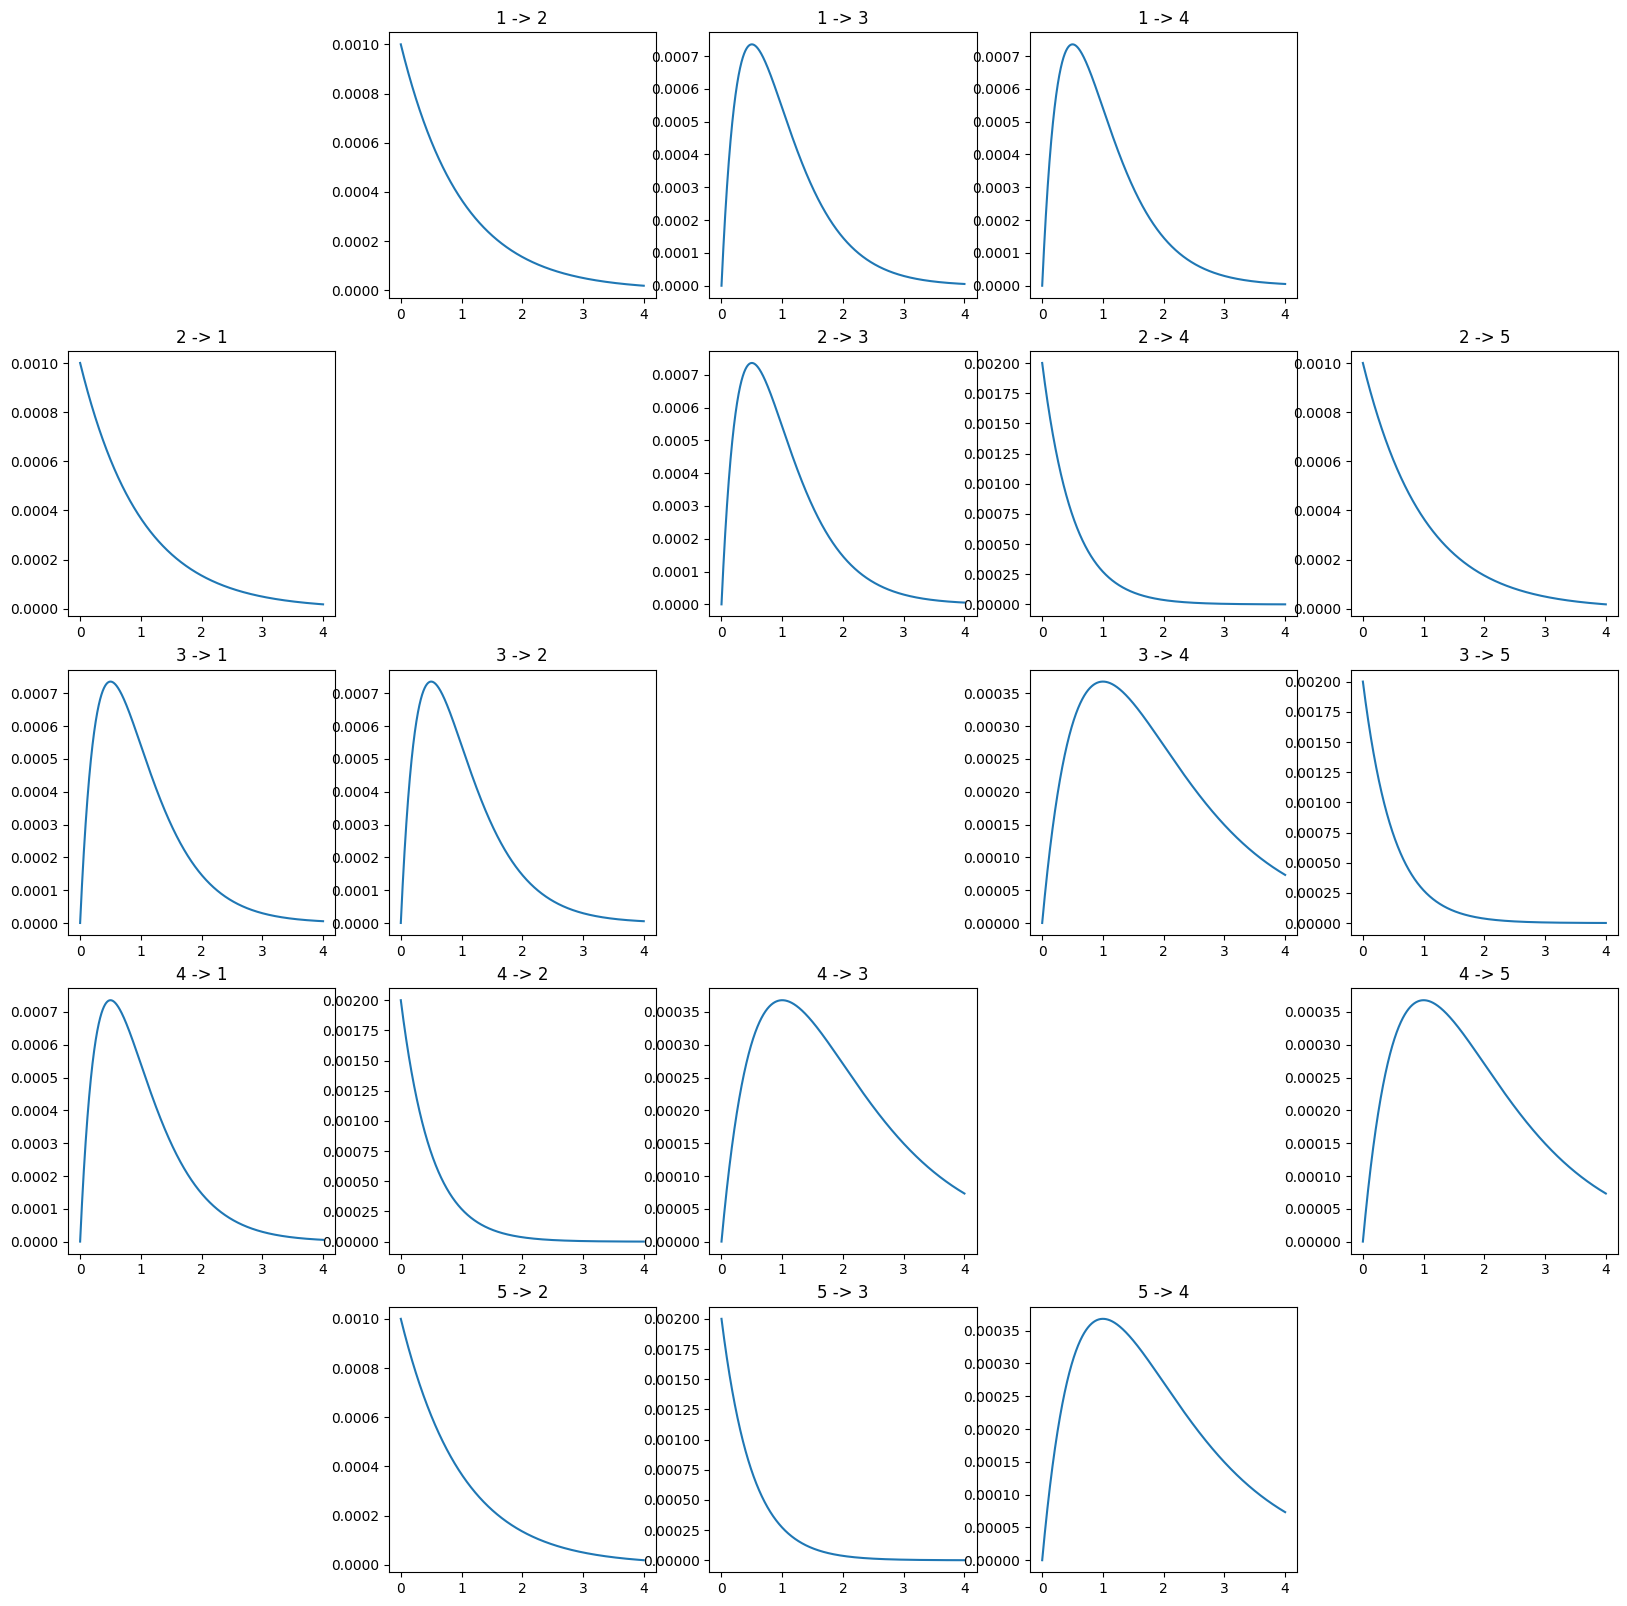

In [3]:
# Plot probability distributions for the heck of it
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i, startNode in enumerate(nodes):
    for j, endNode in enumerate(nodes):
        if gammaParams.loc[startNode, endNode] is np.nan:
            axs[i, j].axis('off')
            continue
        axs[i, j].plot(x, gammaDistributions.loc[(startNode, endNode)])
        axs[i, j].set_title(f'{startNode} -> {endNode}')

#### How much of the probability distribution do we cover with T = [0, 4]

In [4]:
for startNode, endNode in gammaDistributions.index:
    if gammaDistributions.loc[startNode, endNode].isna().any():
        print(f'Edge {startNode} -> {endNode} does not exist')
        continue
    else:
        print(f'Edge {startNode} -> {endNode}: ',f'{gammaDistributions.loc[startNode, endNode].sum()}')

Edge 1 -> 1 does not exist
Edge 1 -> 2:  0.9821936007377353
Edge 1 -> 3:  0.9969831859338893
Edge 1 -> 4:  0.9969831859338893
Edge 1 -> 5 does not exist
Edge 2 -> 1:  0.9821936007377353
Edge 2 -> 2 does not exist
Edge 2 -> 3:  0.9969831859338893
Edge 2 -> 4:  1.0006652060562182
Edge 2 -> 5:  0.9821936007377353
Edge 3 -> 1:  0.9969831859338893
Edge 3 -> 2:  0.9969831859338893
Edge 3 -> 3 does not exist
Edge 3 -> 4:  0.908458348921869
Edge 3 -> 5:  1.0006652060562182
Edge 4 -> 1:  0.9969831859338893
Edge 4 -> 2:  1.0006652060562182
Edge 4 -> 3:  0.908458348921869
Edge 4 -> 4 does not exist
Edge 4 -> 5:  0.908458348921869
Edge 5 -> 1 does not exist
Edge 5 -> 2:  0.9821936007377353
Edge 5 -> 3:  1.0006652060562182
Edge 5 -> 4:  0.908458348921869
Edge 5 -> 5 does not exist


## Generate optimal probabilities and optimal policy tables

In [5]:
probabilities = pd.DataFrame(
    columns= np.arange(0, intervals + 1),
    index=['1', '2', '3', '4', '5'],
)

probabilities.index.names = ['Start node']
probabilities.loc['1', 0] = probabilities.loc['2', 0] = probabilities.loc['3', 0] = probabilities.loc['4', 0] = 0
probabilities.loc['5',] = 1

policy = pd.DataFrame(
    columns= np.arange(0, intervals + 1),
    index=['1', '2', '3', '4', '5']
)
policy.index.names = ['Start node']

#### Horribly bad non-vectorized operation that took 65 min to iterate on my desktop

In [6]:
# # Iterate through all time budgets
# # for timeBudget in np.arange(0, intervals + 1):
# for timeBudget in np.arange(0, intervals + 1):
#     if timeBudget == 0:
#         continue
    
#     # Iterate through the four possible start nodes
#     for startNode in ['1', '2', '3', '4']:
        
#         # Initialize temporary probabilities for each end node
#         tempProbabilities = pd.Series(data=np.zeros(5), index=['1', '2', '3', '4', '5'])
        
#         # Iterate through all possible end nodes
#         for endNode in ['1', '2', '3', '4', '5']:
            
#             # Only iterate through start and end nodes that are adjacent
#             if gammaDistributions.loc[startNode, endNode] is not np.nan:
                
#                 # Calculate optimal probability of reaching node 5 given the start node, end node, and time budget
#                 for timeUsed in np.arange(timeBudget, 0, -1):
#                     temp = gammaDistributions.loc[startNode, endNode][timeUsed] * probabilities.loc[endNode, timeBudget - timeUsed]
#                     # if startNode == '2':
#                     #     print(f'Time budget: {timeBudget}')
#                     #     print(f'Time used: {timeUsed}')
#                     #     print(f'{startNode}-{endNode}')
#                     #     print(f'Probability: {temp}')
#                     tempProbabilities[endNode] += temp
#                     # if startNode == '2':
#                     #     print(f'{tempProbabilities}')
#                     #     print('\n')
        
#         # Store the optimal probability and optimal policy
#         print(f'Start node: {startNode}')
#         print(f'Time budget: {timeBudget}')
#         print(f'{tempProbabilities}')
#         print(f'{np.argmax(tempProbabilities)}')
#         print('\n')
#         probabilities.loc[startNode, timeBudget] = np.nanmax(tempProbabilities)

#### Significantly better vectorized computation method

In [7]:
# Iterate through all time budgets
for timeBudget in np.arange(1, intervals + 1):
# for timeBudget in np.arange(1, 3):

    # Iterate through the four possible start nodes
    for startNode in ['1', '2', '3', '4']:    
        # Initialize temporary probabilities for each end node
        # nodeProbabilities = pd.Series(data=np.zeros(5), index=['1', '2', '3', '4', '5'])
            
        # Calculate optimal probability of reaching node 5 given the start node, end node, and time budget
        # Find relevant gamma distribution values
        gammaCalc = gammaDistributions.xs(startNode, level='startNode').iloc[:,1:timeBudget+1].copy()
        # Reverse gamma distribution values matrix
        gammaCalc = gammaCalc.iloc[:, ::-1]
        # Find relevant probabilities
        probabilitiesCalc = probabilities.iloc[:,0:timeBudget].copy()
        # Calculate the element-wise product of the two matrices
        result = gammaCalc.values * probabilitiesCalc.values
        row_sums = np.sum(result, axis=1)

        # Store the optimal probability
        probabilities.loc[startNode, timeBudget] = np.nanmax(row_sums)
        
        # Store the optimal policy
        if np.nanmax(row_sums) == 0:
            policy.loc[startNode, timeBudget] = np.nan
        else:
            policy.loc[startNode, timeBudget] = str(np.nanargmax(row_sums)+1)

#### Comparison to paper results

In [8]:
display(probabilities.loc[['1','2'], [20,107,271,524,896,1439,2286,3919]])
display(policy.loc[['1','2'], [20,107,271,524,896,1439,2286,3919]])

,20,107,271,524,896,1439,2286,3919
Start node,,,,,,,,
1,0.000187,0.005279,0.03058,0.097315,0.26697,0.54838,0.833525,0.983413
2,0.019791,0.101424,0.237265,0.407649,0.591505,0.762454,0.897879,0.983413


,20,107,271,524,896,1439,2286,3919
Start node,,,,,,,,
1,2,2,2,2,3,3,3,3
2,5,5,5,5,5,5,5,3


## Simulation

For 10000 different link transition time simulations, check if the optimal policy going from node 1 to node 5 is successful or not.

#### Generate 10000 link transition times

In [9]:
# Create 3D dataframe to store simulation times
simulationTimes = pd.DataFrame(
    index=[startNodeIndex, endNodeIndex],
    columns=np.arange(0, 10000)
)
simulationTimes.index.names = ['startNode', 'endNode']

# Generate simulation transition times for each edge
# Generate transition times for each edge
for startNode, endNode in simulationTimes.index:
    
    # Skip if edge does not exist
    if gammaParams.loc[startNode, endNode] is np.nan:
        continue

    # Find alpha and beta parameters for gamma distribution
    alpha, beta = gammaParams.loc[startNode, endNode]
    
    # Create probability distribution for edge by multiplying gamma distribution with time interval
    time = gamma.rvs(a=alpha, scale=1/beta, size=10000)
    simulationTimes.loc[startNode, endNode] = time / timeUnit
    # Dividing by timeUnit helps for indexing during the simulation

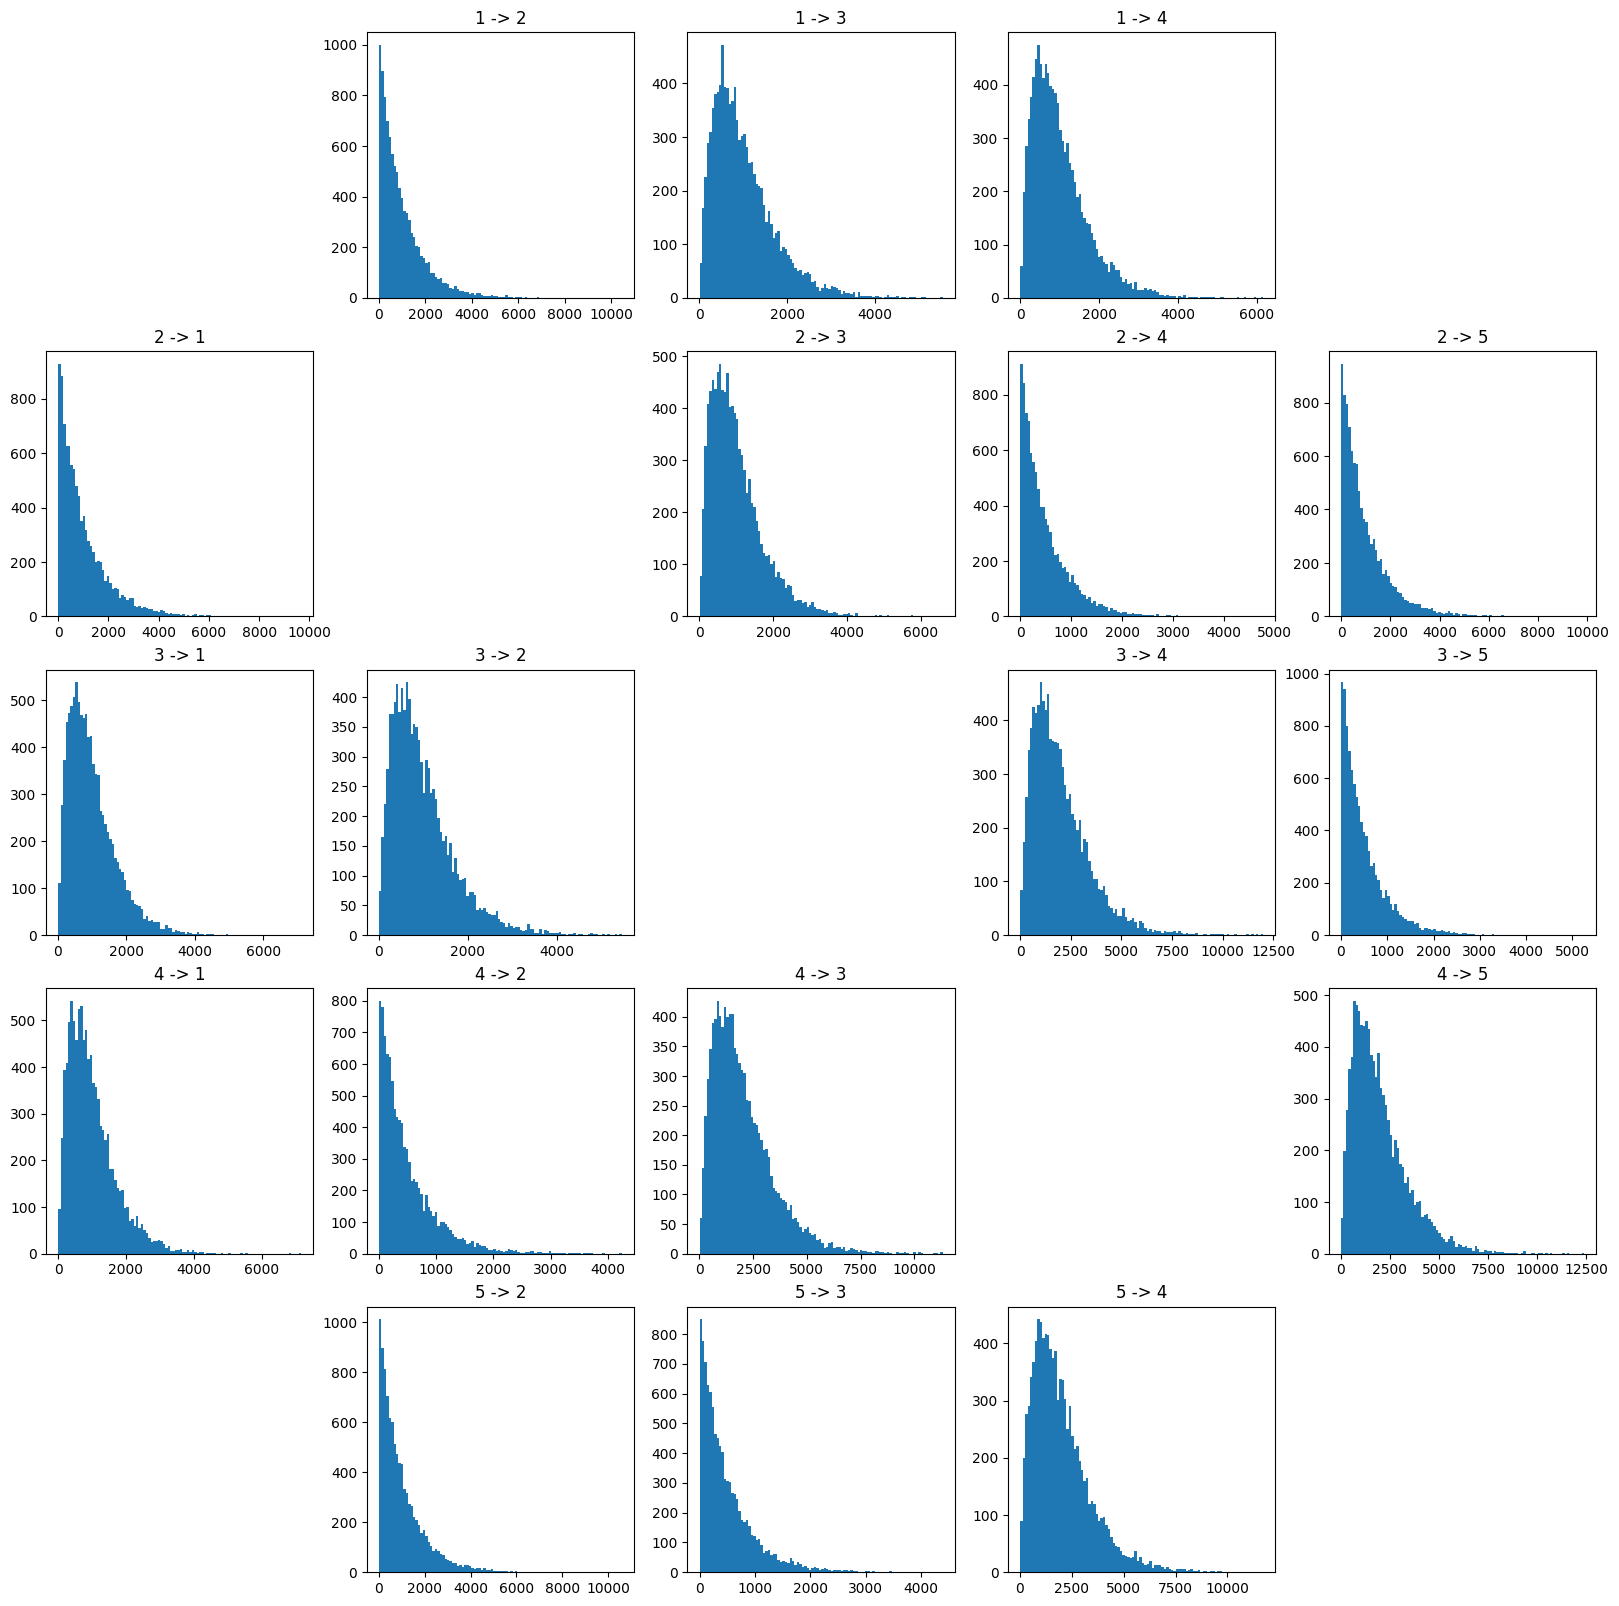

In [10]:
# Plot simulation transition times for the heck of it (it matches the distribution plots yay)
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i, startNode in enumerate(nodes):
    for j, endNode in enumerate(nodes):
        if gammaParams.loc[startNode, endNode] is np.nan:
            axs[i, j].axis('off')
            continue
        axs[i, j].hist(simulationTimes.loc[(startNode, endNode)], bins=100)
        axs[i, j].set_title(f'{startNode} -> {endNode}')

#### Run simulation

In [11]:
# Store simulation times for each iteration
simulationResults = pd.Series(index=np.arange(0, 10000))

# Go through simulation times using the optimal policy and find out if node 5 is reached or not
for i in np.arange(0, 10000):
    
    # Start at node 1 with time budget of 4
    currentNode = '1'
    currentTimeBudget = 4 / timeUnit
    # print(f'Simulation {i+1}')

    # Node traveling iteration
    while currentNode != '5':
        
        # Find the next node
        nextNode = policy.loc[currentNode, currentTimeBudget]
        
        # If we're out of time to get to the next node, break the loop
        # currentTimeBudget == 0 edge case
        if currentTimeBudget == 0:
            simulationResults[i] = -1
            break
        # Normal case
        if currentTimeBudget < simulationTimes.loc[currentNode, nextNode][i]:
            simulationResults[i] = -1
            break
        
        # Otherwise, set up the new time budget and move to the next node
        # We ceil the time for indexing purposes
        currentTimeBudget -= np.ceil(simulationTimes.loc[currentNode, nextNode][i])
        # print(f'{currentNode} to {nextNode} with time left: {currentTimeBudget}')
        currentNode = nextNode
    
    # If we reach node 5, store the time it took to reach it
    if currentNode == '5':
        simulationResults[i] = 4000 - currentTimeBudget
    
    # # If we didn't, what happened
    # else:
    #     print('We got stopped at ', f'{currentNode}',
    #           ' with ',
    #           f'{currentTimeBudget}',
    #           ' time left.')
    #     if currentTimeBudget == 0:
    #         print('Somehow we used up the exact time budget and this statement is here to not destroy the code.')
    #     else:
    #         print('If we continued to ',
    #             f'{nextNode}',
    #             ' we would have had ',
    #             f'{currentTimeBudget - simulationTimes.loc[currentNode, nextNode][i]}',
    #             ' time left.')

#### Simulation Results

Of the 10000 simulations, 128 of them did not reach node 5
This gives a probability of reaching node 5 of 0.9872


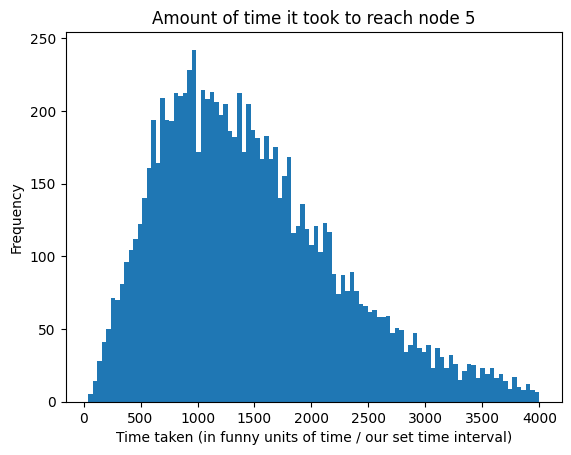

In [12]:
print('Of the 10000 simulations,',
      f'{sum(simulationResults == -1)}',
      'of them did not reach node 5')
print('This gives a probability of reaching node 5 of',
      f'{1 - sum(simulationResults == -1) / 10000}')

# Plot histogram of simulation results
plt.figure()
plt.hist(simulationResults[simulationResults != -1], bins=100)
plt.title('Amount of time it took to reach node 5')
plt.xlabel('Time taken (in funny units of time / our set time interval)')
plt.ylabel('Frequency')
plt.show()